In the last chapter, we build the infrastructure to generate text using the complete GPT model. However, the text generated by the model was giberish, i.e. had no meaning or relation to the given text. This was because the model was not training, the weights in the model were completely random. So in this section we will train the model on a smaller set of text. I will try to train my model using more and more text so that it is better but only till the point where my GPU supports.


At the beginning of the chapter, the same thing is repeated as the last chapter, which is generated random text from the given input, I am skiping that part and moving on to the calculation of loss.

Calculation of loss is a very crucial part of the training process, we try to minimize this loss while training the model to make it more accurate. To do this we use backpropogation, which can be intuitively understood as trying to move the model in the opposite direction of the greatest descent. So, at any given point we calculate the gradient of the loss function and check that towards which direction in the vector space, we find the highest ascent. The direction opposite to that it taken and the model parameters are trained as such. Therefore, the loss function of any model is very important, we studied two types of loss function in this chapter. Cross-entropy and Perplexitiy, Cross entropy loss basically compares the true values and the predicted values and identifies how far they are from each other. Mathematically, it takes the negative of logarithm of the values and takes their average. Perplexitiy is just the exponent of the final loss calculated by cross entropy, so it gives a higher value and it indicates among how many number of tokens is the model unsure which could be the correct one.  

In [1]:
import torch
import fitz
import torch.nn as nn
import tiktoken
from important_GPT_blocks import simple_text_gen
from important_GPT_blocks import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

tokenizer = tiktoken.get_encoding("gpt2")

In [2]:
statement_1 = "Now I have become"
statement_2 = "With great power comes"

inputs = [text_to_token_ids("Now I have become", tokenizer), text_to_token_ids("With great power comes", tokenizer)]
print(inputs)

targets = [text_to_token_ids(" I have become death", tokenizer), text_to_token_ids(" great power comes great", tokenizer)]
print(targets)

[tensor([[3844,  314,  423, 1716]]), tensor([[3152, 1049, 1176, 2058]])]
[tensor([[ 314,  423, 1716, 1918]]), tensor([[1049, 1176, 2058, 1049]])]


In [3]:
inputs = torch.tensor([[3844,  314,  423, 1716],
                      [3152, 1049, 1176, 2058]])

targets = torch.tensor([[314,  423, 1716, 1918],
                      [1049, 1176, 2058, 1049]])


One thing i noticed here, for the targets, if i didn't keep a space before the first character, then the token id for that token is different than the one with the space. This means that the tokenizer gives a specail place to those tokens at the start of a sentence or a sequence. In order to maintain the same token ids I had to provide a space. 

In [4]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
probas.shape

torch.Size([2, 4, 50257])

In [5]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
token_ids

tensor([[[34713],
         [37311],
         [50225],
         [21805]],

        [[19389],
         [21853],
         [ 8056],
         [29179]]])

In [6]:
import torch
print(torch.cuda.is_available())

True


In [7]:
print(token_ids_to_text(targets[0], tokenizer))
print(token_ids_to_text(token_ids[0].flatten(), tokenizer))

 I have become death
":""," mystic reclaimed Pew


In [8]:
text_ids = 0
target_probas_1 = probas[text_ids, [0,1,2,3], targets[text_ids]]
print(target_probas_1)

text_ids = 1
target_probas_2 = probas[text_ids, [0,1,2,3], targets[text_ids]]
print(target_probas_2)

tensor([2.2187e-05, 2.7385e-05, 3.0733e-05, 1.0088e-05])
tensor([1.9483e-05, 2.1743e-05, 1.2926e-05, 1.4988e-05])


It picks the predicted probability assigned to the correct class at each time step 0, 1, 2, and 3 in sequence 0.

Let’s break the indexing:

probas[0, [0, 1, 2, 3], targets[0]]
probas[0] → gets the (T, C) tensor for the first sequence.

targets[0] → shape: (T,), gives true class indices for each time step in sequence 0.

Now, you're doing advanced indexing:
probas[0, t, targets[0][t]] for t ∈{0,1,2,3}
So this grabs:

[
  probas[0, 0, targets[0, 0]],
  probas[0, 1, targets[0, 1]],
  probas[0, 2, targets[0, 2]],
  probas[0, 3, targets[0, 3]]
]
That is: the predicted probability of the correct class at each of the first 4 time steps of sequence 0.

In [9]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
log_probas

tensor([-10.7160, -10.5055, -10.3902, -11.5042, -10.8460, -10.7362, -11.2562,
        -11.1083])

In [10]:
avg_log_probas = torch.mean(log_probas)
neg_avg_log_probas = avg_log_probas * -1
neg_avg_log_probas

tensor(10.8828)

This was the manual implementation of the cross entropy loss, now we will use the inbuilt function.

In [11]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

loss = nn.functional.cross_entropy(logits_flat, targets_flat)
loss

tensor(10.8828)

In [12]:
perplexity = torch.exp(loss)
perplexity.round()

tensor(53253.)

This means that the model is unsure between 62115, but total number of tokens are 50278 something, i think the extra ones are byte pair encodings. 

In [13]:
text_data = ""

file_path_1= "relativity.pdf"
doc1 = fitz.open(file_path_1)
for page in doc1:
    text_data += page.get_text()


In [14]:
total_chars = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(total_chars)
print(total_tokens)

189883
43284


In [15]:
from important_GPT_blocks import create_dataloader_v1

train_ratio = 0.90
split_idx = int(train_ratio * total_chars)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(train_data,
                                    batch_size=2,
                                    max_length=GPT_CONFIG_124M['context_length'],
                                    stride=GPT_CONFIG_124M['context_length'],
                                    drop_last=True,
                                    shuffle=True,
                                    num_workers=0
                                    )

val_loader = create_dataloader_v1(val_data,
                                    batch_size=2
                                    ,
                                    max_length=GPT_CONFIG_124M['context_length'],
                                    stride=GPT_CONFIG_124M['context_length'],
                                    drop_last=False,
                                    shuffle=False,
                                    num_workers=0
                                    )

Here we have separated the given data into data loaders fro training and validation. Due to the 90% split for training data, the val loader will have lesser number of batches. Now we will calculate the cross entropy loss.

In [16]:
def loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def loss_batch_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else : 
            break
    return total_loss/num_batches

In [17]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()  # optional, cleans up interprocess memory


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = loss_batch_loader(train_loader, model, device)
    val_loss = loss_batch_loader(val_loader, model, device)

print(train_loss)
print(val_loss)

10.979639454891807
10.975638151168823


So now we have a function ready that can calculate the loss. Now we will start creating the training loop and train our model on data.

In [19]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_seen_tokens = [], [], []
    tokens_count, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_count += input_batch.numel()
            global_step += 1
            
        if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_seen_tokens.append(tokens_count)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_seen_tokens

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = loss_batch_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = loss_batch_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = simple_text_gen(
            model=model, idx=encoded,
            max_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) 
    model.train()

In [20]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="With great power comes great", tokenizer=tokenizer
)

Ep 1 (Step 000075): Train loss 5.460, Val loss 6.153
With great power comes great, and the                                               
With great power comes great                                                  
With great power comes great is not in the Part II: The Special Theory of Relativity Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein Albert Einstein
With great power comes great and for the same time of the same way, the reference-rodynamical behaviour of the same                            
With great power comes great general law of the (Supplementary to be in the         The theory of relativity,             Part II: Relativity: The General Theory of Rel
Ep 6 (Step 000455): Train loss 1.019, Val loss 6.079
With great power comes great accuracy. In this connection the the theory of light in vacuo has to the embankment. the reference to be travel

The model has trained quite good, the training loss has become significantly low, however the val loss is still pretty high. I am directly using the code given in the book to visualise the losses in a graph

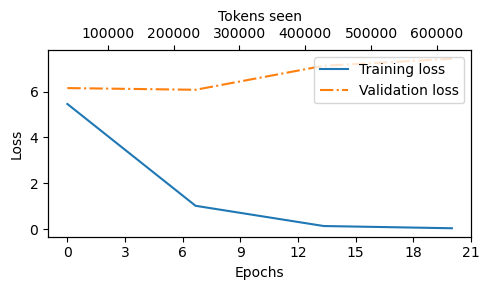

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  
    
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

I tried training the model on more data, i went upto 1.8 lakh tokens but that took way too much time. So, i reduced it and finally settled at 70k tokens. The training loss was very low. Now trying to generate statements using the trained model and then introducting temperature scaling and top-k sampling to make the model even better. 

In [22]:
model.to("cpu")
model.eval()
token_ids = simple_text_gen( model=model,
                            idx=text_to_token_ids("With great power comes", tokenizer),
                            max_tokens=25,
                            context_size=GPT_CONFIG_124M["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

With great power comes as a crucial test in favour of
the theory of relativity, for the electrodynamics of Maxwell-Lorent


Temperature scaling is a method we use to introduce randomness and give variability to the model so that it does not completely stick to the data it has been trained on. The way it works is, for a temperature scale of 1 it directly uses the logit values but for a temperature of lower than 1, it highly scales the ones which are larger closer to 100%, i.e. reduces the value of low value logits and increases the value of high value(kinda like the govt). Whereas, a temperature higher than 1 would display a spread of probabilities into all the logits. This is useful to control how much the model tries to include different tokens. So, if we want the model to experiment and give different results than a higher temperature is used and if we want the model to stick to the exact data being shared then a lower temperature is used. So for medical or educational, or crucial information related tasks the temperature should be kept low, but for creative purposes like writing, story making etc the temperature should be high

Top-k sampling is another method where we decide a certain value k, that is how many tokens we are selecting that we want the model to choose between, so let's say we choose k to be 4, then the top 4 highest values are kept as it is, the rest are set to -inf. So, when we apply softmax, the top 4 values sum up to 1, the rest are equal to 0. 

In [8]:
def generate(model, idx, max_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probs, num_samples=1) 

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) 
            
        if idx_next == eos_id:  
            break
        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [24]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("With great power comes", tokenizer),
    max_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(token_ids_to_text(token_ids, tokenizer))

With great power comes as a crucial test in favour of
the theory of relativity, for the electrodynamics of Maxwell-Lorent


In [25]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Once upon a time, there", tokenizer),
    max_tokens=20,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=20,
    temperature=2.1
)

print(token_ids_to_text(token_ids, tokenizer))

Once upon a time, there that the law of a piece of motion ? This form whose plays every reference-
other marked out


Training the model on a phyiscs book might not have been the best idea. It is not able to talk anything except for physics. :(

In [26]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort takes", tokenizer),
    max_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort takes place with the
Lorentz transformation, the law of the transmission of light in vacuo is satisfied both for the


I think i will train this again on a different book based on a general topic, so that the english becomes better.

Ep 1 (Step 000195): Train loss 5.886, Val loss 7.281
With great power comes great The habits. The habits is a The habits. The habits is a The habits’s The habits. The habits’s the The habits’s The habits. The habits. 
With great power comes great, but you’re a you’re a you can be you can be a you can be a you’re a you are a you can be a you can be a you can
With great power comes great habits. The more likely to the The goal is the The goal is the The type of the The goal is the type of the type of the type of the type of the type of the The goal is the type of
With great power comes great The 1st Law: Make it is the The 1st Law: Make it is not only The 1st Law: Make it is the The 1st Law: Make it is an action is an opportunity, and The 1
With great power comes great way to be to bundling is to be more the cue. The more likely to be more likely to be more likely to be a habit is a habit is a habit is a habit stacking is to be a habit stacking is a habit
Ep 6 (Step 001175): Train loss 2

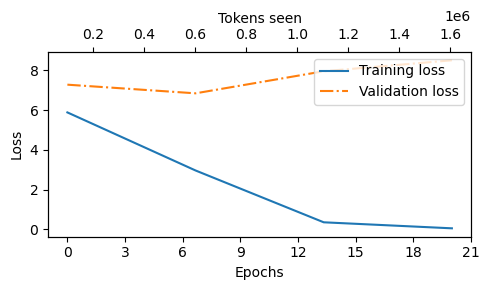

With great power comesal team as those you tend to be filled out every system is educated and working.
How an action has made. In


In [27]:
torch.manual_seed(123)
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
new_text_data = ""

file_path_1= "atomic.pdf"
new_doc = fitz.open(file_path_1)
for page in new_doc:
    new_text_data += page.get_text()

new_chars = len(new_text_data)
splt = int(train_ratio * new_chars)
new_train_data = new_text_data[:splt]
new_val_data = new_text_data[splt:]

new_train_loader = create_dataloader_v1(new_train_data,
                                    batch_size=2,
                                    max_length=GPT_CONFIG_124M['context_length'],
                                    stride=GPT_CONFIG_124M['context_length'],
                                    drop_last=True,
                                    shuffle=True,
                                    num_workers=0
                                    )

new_val_loader = create_dataloader_v1(new_val_data,
                                    batch_size=2,
                                    max_length=GPT_CONFIG_124M['context_length'],
                                    stride=GPT_CONFIG_124M['context_length'],
                                    drop_last=False,
                                    shuffle=False,
                                    num_workers=0
                                    )

new_model = GPTModel(GPT_CONFIG_124M)
new_model.to(device)
optimizer = torch.optim.AdamW(new_model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    new_model, new_train_loader, new_val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="With great power comes great", tokenizer=tokenizer
)

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

token_ids = generate(
    model=new_model,
    idx=text_to_token_ids("With great power comes", tokenizer).to(device),
    max_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(token_ids_to_text(token_ids, tokenizer))

Now let's see how the new model reacts to the old prompt statments

In [29]:
token_ids = generate(
    model=new_model,
    idx=text_to_token_ids("Every effort takes", tokenizer).to(device),
    max_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort takes this list percenton, wheny and make there
2017, where I give his wife by writing about in the Monday and


In [33]:
token_ids = generate(
    model=new_model,
    idx=text_to_token_ids("Once upon a time, there", tokenizer).to(device),
    max_tokens=20,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=20,
    temperature=2.1
)

print(token_ids_to_text(token_ids, tokenizer))

Once upon a time, there
oficallyonia credit.* over time and back on At the second? And when there are part


Yeah so now i have two models, one talks about space and physics and one gives life lessons. I understood why we need to train so much so that it can become general stream. 

In [35]:
torch.save(model.state_dict(), "physics_model.pth")
torch.save(new_model.state_dict(), "atomic_model.pth")

I tried downloading the weights using the tf method but it threw error and issues, so i will use the alternate method using pytorch.

In [5]:
from importlib.metadata import version
import torch
import torch.nn as nn
import os
import tiktoken

pkgs = ["torch"]
for p in pkgs: 
    print(f"{p} version : {version(p)}")

torch version : 2.5.1


In [6]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


CHOOSE_MODEL = "gpt2-large (774M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [7]:
file_name = "gpt2-large-774M.pth"
import os
import urllib.request

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

In [8]:
def generate(model, idx, max_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probs, num_samples=1) 

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) 
            
        if idx_next == eos_id:  
            break
        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [9]:
from important_GPT_blocks import GPTModel
gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1280)
  (pos_emb): Embedding(1024, 1280)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1280, out_features=1280, bias=True)
        (W_key): Linear(in_features=1280, out_features=1280, bias=True)
        (W_value): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU()
          (2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [10]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")
from add_training_data import text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("With great power", tokenizer).to(device),
    max_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 With great power comes great responsibility.

"I think it's a great opportunity for me. I'm really looking forward to it. I'm really looking forward


In [12]:
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Now I have become death", tokenizer).to(device),
    max_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Now I have become deathly ill, and the Lord has given me the iniquity of the law, and I am a man, and not the man I was,


In [14]:
token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Once upon a time, there was a little boy named percy", tokenizer).to(device),
    max_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Once upon a time, there was a little boy named percy, who was a very good and good-for-nothing man. He was a good man, and a good man's son, and a good
